In [17]:
import os
import sys
import rrdtool
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from auserverdata.preparation.rrd import (
    parse_rrds_for_all_collectd_servers,
    parse_rrds_for_all_snmp_servers,
    get_time_series_data_for_collectd_servers,
    get_time_series_data_for_snmp_servers,
    get_feature_names_for_timestamp_set,
    get_feature_names_with_substring_present,
    map_feature_names_to_timestamps,
    map_timestamp_sets_to_feature_names,
    print_timestamp_set_to_feature_names_map_info
)
from auserverdata.local import get_local_config
from auserverdata.analysis import (
    plot_time_series_data_on_single_plot,
    plot_time_series_data_in_vertical_stack
)
from joblib import Parallel,delayed
import pyarrow.parquet as pq
import pyarrow.compute as pc

In [6]:
local_config = get_local_config()

In [69]:
# results = parse_rrds_for_all_snmp_servers(snmp_path='/home/bshook/Projects/server-log-api/rrd/original/snmp', 
#                                           dst=f'/home/bshook/Projects/server-log-api/rrd/parsed/snmp_parsed_data.parquet')

In [70]:
# results = parse_rrds_for_all_collectd_servers(collectd_path='/home/bshook/Projects/server-log-api/rrd/original/collectd', 
#                                               dst=f'/home/bshook/Projects/server-log-api/rrd/parsed/collectd/parsed_data.parquet',
#                                               n_jobs=-1)

In [8]:
collectd_ts_df = get_time_series_data_for_collectd_servers(rrd_dir=local_config.rrd_dir, collectd_servers=['gpu1'])

In [9]:
timestamps_per_feature = map_feature_names_to_timestamps(collectd_ts_df)
features_per_timestamp_set = map_timestamp_sets_to_feature_names(timestamps_per_feature)

In [10]:
print_timestamp_set_to_feature_names_map_info(features_per_timestamp_set)

************************************************************
Info about Timestamp Set 0
    Number of timestamps: 1200
    Number of features with the these timestamps: 225
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:28
    End timestamp: 2023-05-20 04:11:18
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 1
    Number of timestamps: 1200
    Number of features with the these timestamps: 8
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:33
    End timestamp: 2023-05-20 04:11:23
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 2
    Number of timestamps: 1200
    Number of features with the these timestamps: 1
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2020-07-09 14:49:41
    End timestamp: 2020-07-09 18:09:31
    Total duration: 0 d

In [13]:
feature_names = get_feature_names_for_timestamp_set(
                    features_per_timestamp_set,
                    timestamp_set = 0
                    )

In [15]:
len(feature_names)

225

In [19]:
cpu_user_feature_names = get_feature_names_with_substring_present(
    feature_names,
    substring = 'cpu-user'
    )

In [20]:
cpu_user_feature_names

[('gpu1', 'cpu-8', 'cpu-user', 'value'),
 ('gpu1', 'cpu-1', 'cpu-user', 'value'),
 ('gpu1', 'cpu-20', 'cpu-user', 'value'),
 ('gpu1', 'cpu-10', 'cpu-user', 'value'),
 ('gpu1', 'cpu-7', 'cpu-user', 'value'),
 ('gpu1', 'cpu-16', 'cpu-user', 'value'),
 ('gpu1', 'cpu-18', 'cpu-user', 'value'),
 ('gpu1', 'cpu-22', 'cpu-user', 'value'),
 ('gpu1', 'cpu-19', 'cpu-user', 'value'),
 ('gpu1', 'cpu-3', 'cpu-user', 'value'),
 ('gpu1', 'cpu-15', 'cpu-user', 'value'),
 ('gpu1', 'cpu-23', 'cpu-user', 'value'),
 ('gpu1', 'cpu-14', 'cpu-user', 'value'),
 ('gpu1', 'cpu-9', 'cpu-user', 'value'),
 ('gpu1', 'cpu-13', 'cpu-user', 'value'),
 ('gpu1', 'cpu-21', 'cpu-user', 'value'),
 ('gpu1', 'cpu-6', 'cpu-user', 'value'),
 ('gpu1', 'cpu-2', 'cpu-user', 'value'),
 ('gpu1', 'cpu-0', 'cpu-user', 'value'),
 ('gpu1', 'cpu-5', 'cpu-user', 'value'),
 ('gpu1', 'cpu-11', 'cpu-user', 'value'),
 ('gpu1', 'cpu-17', 'cpu-user', 'value'),
 ('gpu1', 'cpu-12', 'cpu-user', 'value'),
 ('gpu1', 'cpu-4', 'cpu-user', 'value')]

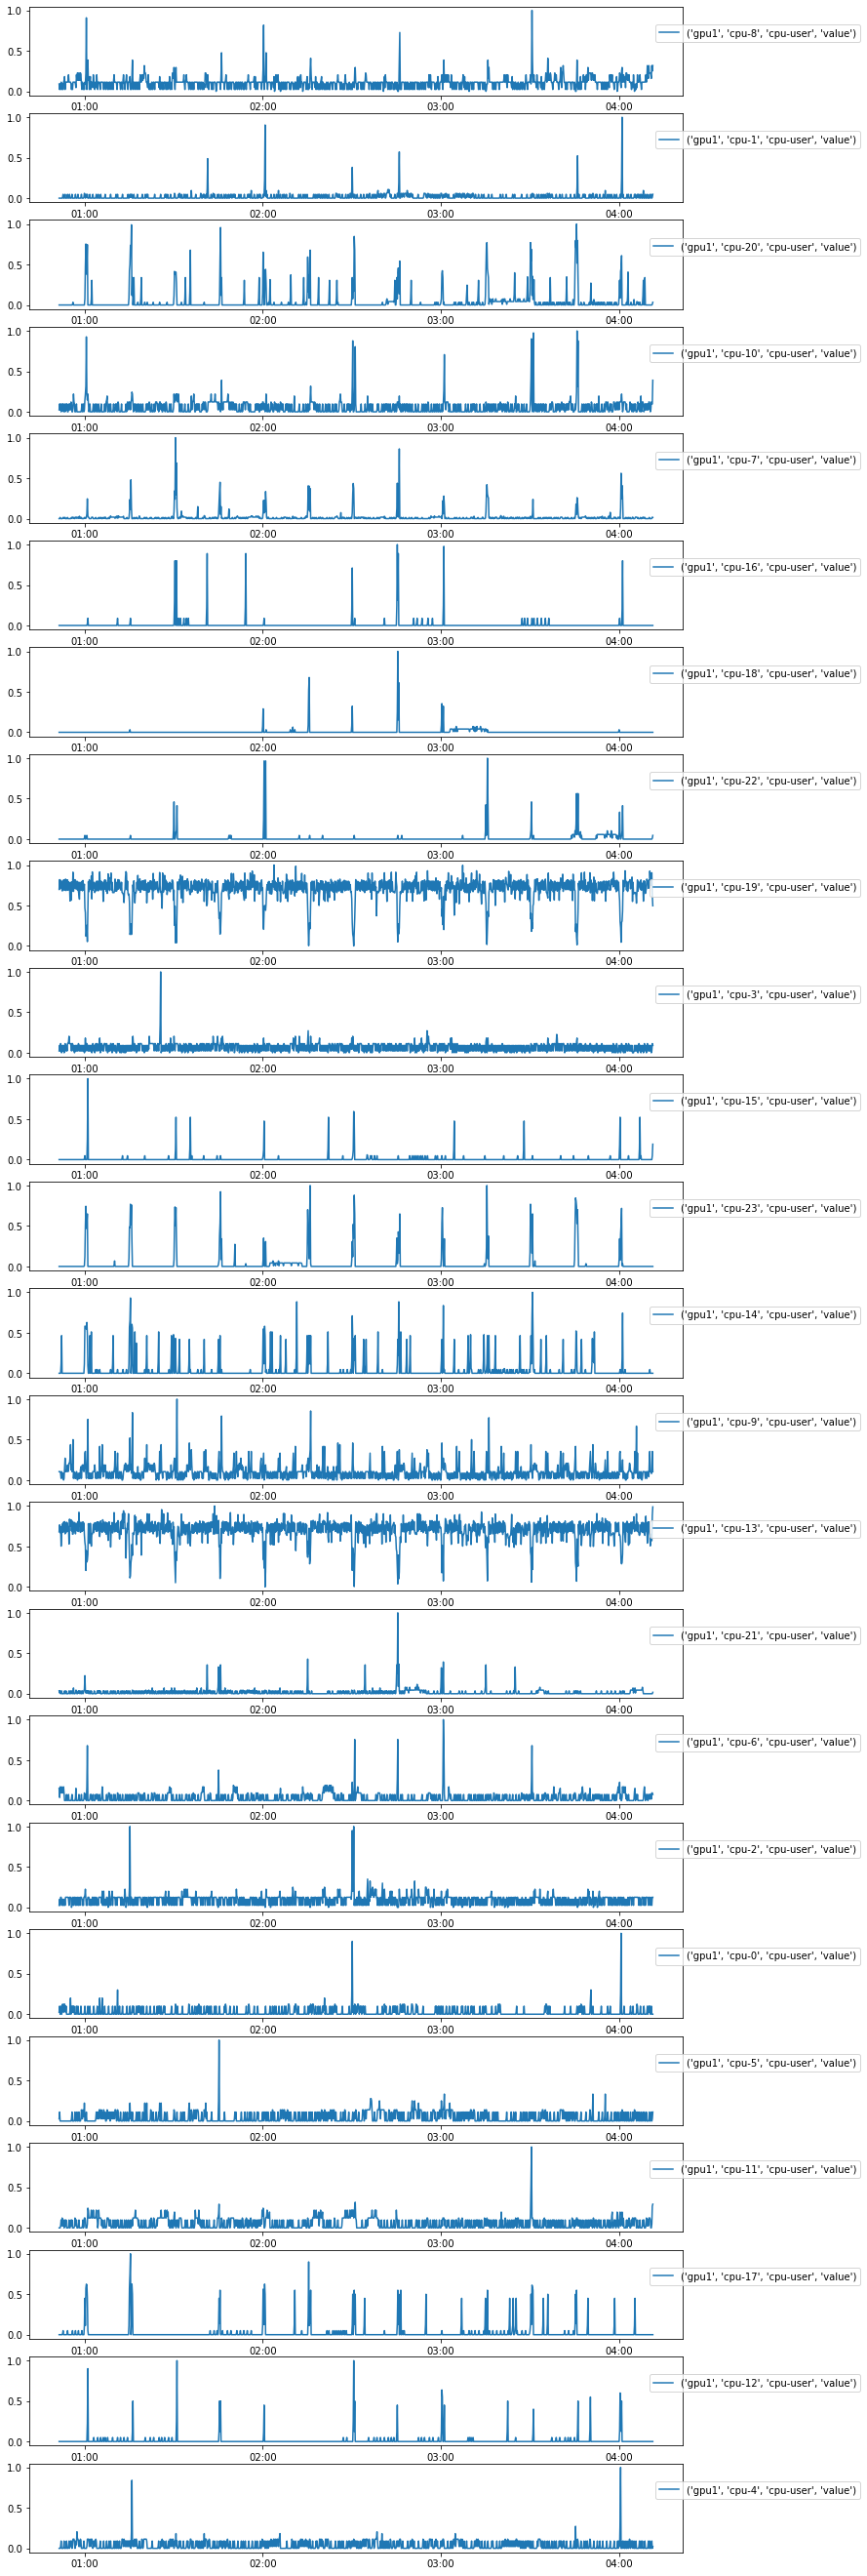

In [21]:
plot_time_series_data_in_vertical_stack(
    collectd_ts_df[cpu_user_feature_names]
    )